<a href="https://colab.research.google.com/github/Jahnavi-Jaolekar/NYC-Taxi-time-prediction/blob/main/NYC_taxi_trip_time_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Title : NYC taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City**


# **BUSINESS CONTEXT**
Task is to build a model that predicts the total ride duration of taxi trips in New York City. Primary dataset is the one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

The primary goal of this project is to build a fundamental machine learning model that can forecast the typical trip time and cost for a given pickup location, dropoff location, date, and time. In order to gain an advantage over competitors and give customers greater value, every company today must effectively use its data. Making critical business decisions now often involves using machine learning, and libraries like data prep and sklearn make it possible for anyone, regardless of coding proficiency or domain expertise, to create models. One of the most potent libraries for machine learning is called Scikit Learn.

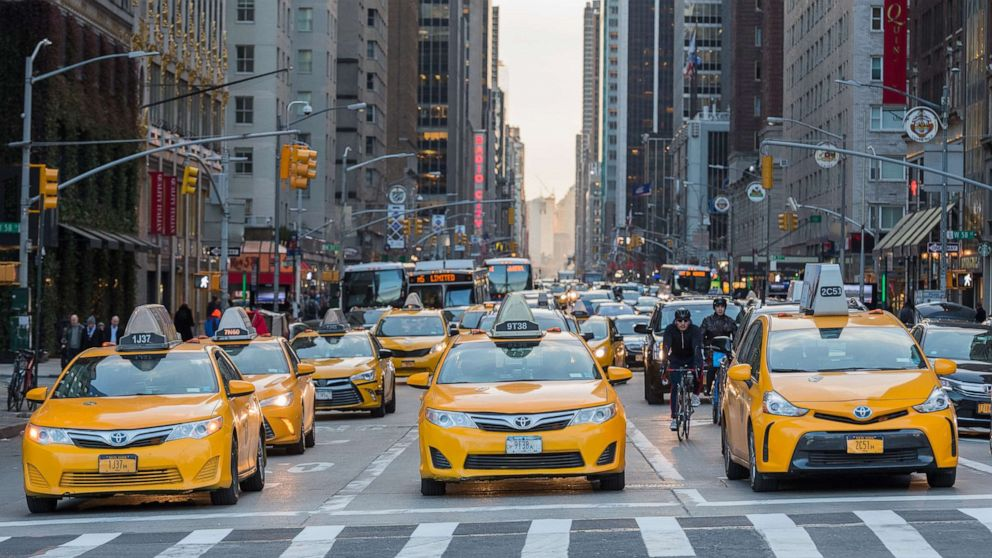

## **Understanding Dataset**
Importing necessary libraries and mounting drive

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import math
import xgboost
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from datetime import datetime
import datetime
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# lets take a look at the data set
taxi_df=pd.read_csv('/content/drive/MyDrive/capstone project 2/Copy of NYC Taxi Data.csv')
taxi_df.head()

# **Column Details**


*   **Id**: A unique identifier for each trip
*   **Vendor Id**: A unique identifier for each trip

*   **Pickup Datetime**: A unique identifier for each trip
*   **Dropoff Datetime**: A unique identifier for each trip

*   **Passenger Count**: The number of passengers in the vehicle (driver entered value)
*   **Pickup Longitude**: The number of passengers in the vehicle (driver entered value)

*   **Pickup Latitude**: The latitude where the meter was engaged
*   **Dropoff Longitude**: The longitude where the meter was disengaged

*   **Dropoff Latitude**: The latitude where the meter was disengaged

*   **Store and Fwd Flag**: This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip.
*   **Trip Duration**: Duration of time in seconds
















In [ ]:
rows=taxi_df.shape[0]
columns=taxi_df.shape[1]
print(f'Number of rows in dataset are {rows}')
print(f'Number of columns in dataset are {columns}')

In [ ]:
taxi_df.info()

In [ ]:
taxi_df.describe()

In [ ]:
# Defining function to determine null values in dataset and datatype of the data
def brief():
  values=pd.DataFrame(index=taxi_df.columns)
  values['Null Count']= taxi_df.isnull().sum()
  values['Dtype']=taxi_df.dtypes
  return values 

In [ ]:
brief()

### As we can see that we do not have any null values in the dataset, therefore we can move forward with the dataset...

In [ ]:
# Converting timestamp to datetime format
taxi_df['pickup_datetime']=pd.to_datetime(taxi_df['pickup_datetime'])
taxi_df['dropoff_datetime']=pd.to_datetime(taxi_df['dropoff_datetime'])
taxi_df.head()

## **DATA VISUALIZATION**

In [ ]:
#Distribution of the vendor id for the taxi trip
sns.countplot(x='vendor_id',data=taxi_df)

In [ ]:
# Distribution of pickups and dropoffs on daily basis
taxi_df['pickup_day']=taxi_df['pickup_datetime'].dt.day_name()
taxi_df['dropoff_day']=taxi_df['dropoff_datetime'].dt.day_name()

figure, ax= plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.countplot(x='pickup_day', data = taxi_df, ax=ax[0])
ax[0].set_title('No. of pickups done on each day')

sns.countplot(x='dropoff_day', data = taxi_df, ax=ax[1])
ax[1].set_title('No. of dropoffs done on each day')

plt.tight_layout()

### Above plots interpret that in a week, "thursday", "friday", and "saturday" have higher number of pickups and dropoffs.

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

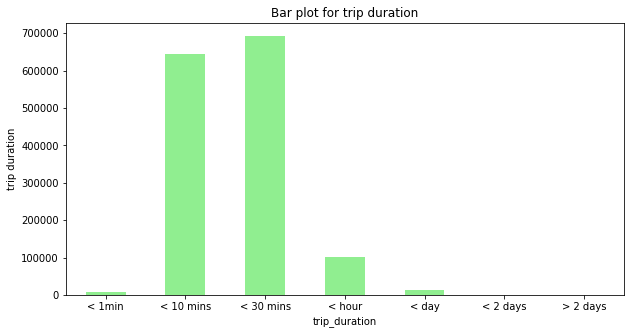

In [71]:
plt.figure(figsize=[10,5])
labels=['< 1min','< 10 mins','< 30 mins','< hour','< day','< 2 days','> 2 days']
taxi_df.groupby(pd.cut(taxi_df['trip_duration'],bins=[0,60,600,1800,3600,86400,86400*2,10000000],labels=labels))['trip_duration'].count().plot(kind='bar', color='lightgreen', fontsize=10)
plt.title("Bar plot for trip duration")
plt.ylabel("trip counts")
plt.ylabel("trip duration")
plt.xticks(rotation=0)

Text(0.5, 1.0, 'Distribution of total dropoff hour')

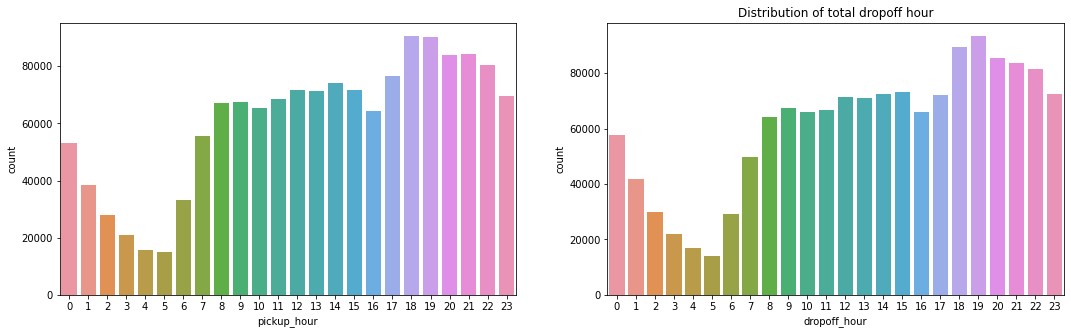

In [72]:
figure, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,5))
taxi_df['pickup_hour'] = taxi_df['pickup_datetime'].dt.hour 
taxi_df['dropoff_hour'] = taxi_df['dropoff_datetime'].dt.hour 
sns.countplot(x = taxi_df['pickup_hour'], ax=ax[0] )
plt.title('Distribution of total pickup hour')

sns.countplot(x = taxi_df['dropoff_hour'], ax=ax[1])
plt.title('Distribution of total dropoff hour')

### Distribution of pickup and dropoff hours follows same pattern, it shows that most of the pickups and dropoffs are in the evening( x axis represesnts time in hrs, and peak is >15hr).

Text(0.5, 1.0, 'Distribution of passenger count')

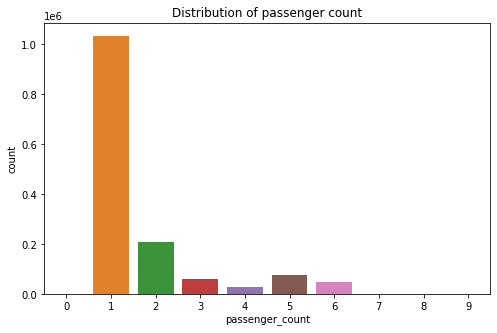

In [73]:
# Distribution of passenger count
plt.figure(figsize=(8,5))
ax=sns.countplot(x=taxi_df['passenger_count'])
plt.title('Distribution of passenger count')

### Barplot infers that most of the rides have only one passenger in taxi...

### **Determining correlation between independent variables**

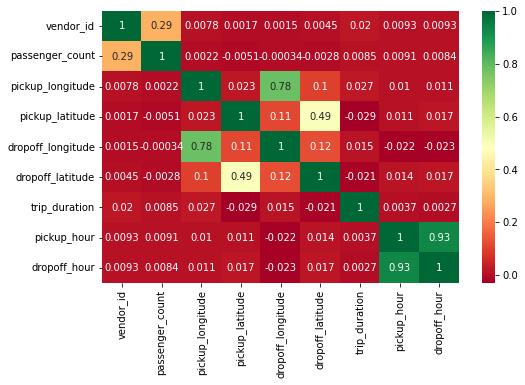

In [74]:
plt.figure(figsize=(8,5))
sns.heatmap(taxi_df.corr(), annot=True, cmap='RdYlGn')

Above heatmap clearly shows that pickup longitude and dropoff longitude are highly correlated to each other.
(Multicollinearity: when independent variables are related to each other might beget false results during model prediction)

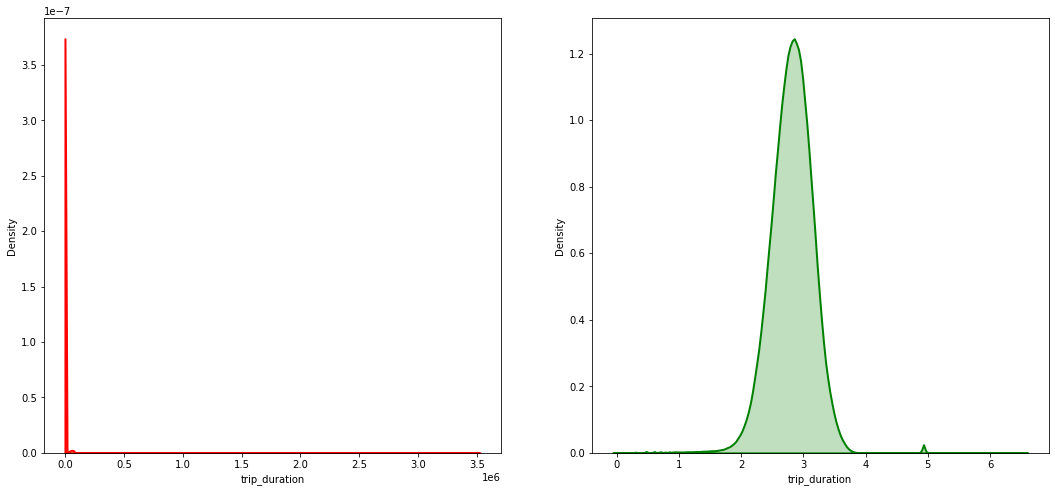

In [75]:
fig,ax=plt.subplots(1,2, figsize=(18,8))
sns.distplot(taxi_df.trip_duration, hist= False, kde= True, kde_kws= {'shade':True, 'linewidth':2}, label= 'non_normal', color='red', ax=ax[0])
sns.distplot(np.log10(taxi_df['trip_duration']), hist= False, kde= True, kde_kws={'shade':True, 'linewidth':2}, label='normal', color='green',ax=ax[1])

Graph is positivley skewed so it needs to be regularized... we used log transformation to convert this into normal distribution

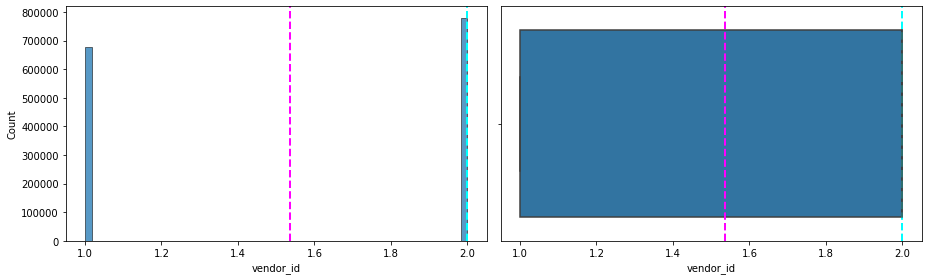

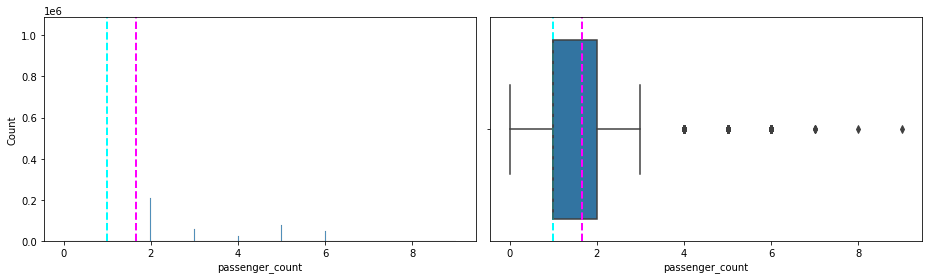

Error in callback <function flush_figures at 0x7f0c89562050> (for post_execute):


KeyboardInterrupt: ignored

In [68]:
numeric_features = ['vendor_id', 'passenger_count', 'trip_duration', 'pickup_hour', 'dropoff_hour']
numeric_features

for col in numeric_features:
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,4))
  sns.histplot(data=taxi_df, x=col, ax=ax[0])
  ax[0].axvline(taxi_df[col].mean(), color='magenta', linestyle='dashed', linewidth=2)
  ax[0].axvline(taxi_df[col].median(), color='cyan', linestyle='dashed', linewidth=2)
  sns.boxplot(data=taxi_df, x=col, ax=ax[1])
  ax[1].axvline(taxi_df[col].mean(), color='magenta', linestyle='dashed', linewidth=2)
  ax[1].axvline(taxi_df[col].median(), color='cyan', linestyle='dashed', linewidth=2)
  plt.tight_layout()

In [76]:
#importing geopy library
from geopy.distance import geodesic

#Creating the function for calculating distance between pickup and dropoff
def distance_cal(pickup_lat,pickup_long,dropoff_lat,dropoff_long):
 
 start_coordinates=(pickup_lat,pickup_long)
 stop_coordinates=(dropoff_lat,dropoff_long)
 
 return geodesic(start_coordinates,stop_coordinates).km

 #Applying the function to our dataset and creating the feature ‘distance’.
taxi_df['distance'] = taxi_df.apply(lambda x: distance_cal(x['pickup_latitude'],x['pickup_longitude'],x['dropoff_latitude'],x['dropoff_longitude'] ), axis=1)

# **Outlier detection** 
### Interquartile range measures the spread of the middle half of our data.
### Formula: Q3 - Q1
### where Q1- quartile 1 and Q3- quartile 3

### lower limit of the data is given by Q1-1.5*IQR
### upper limit of the data is given by Q3+1.5*IQR

### **We will be using percentile method to detect and remove outliers from the data**

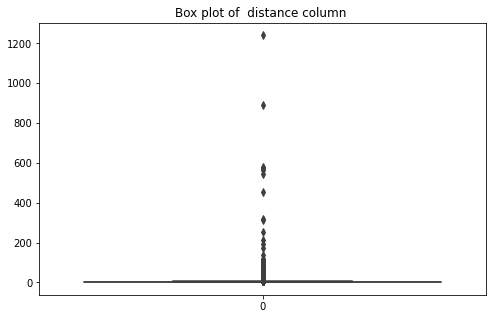

In [81]:
plt.figure(figsize=(8,5))
plt.title("Box plot of  distance column ")
ax = sns.boxplot(data=taxi_df['distance'], orient="v")

In [80]:
# Assigning different quarters to distance column
distance_Q1=np.percentile(taxi_df['distance'], 25)
print(distance_Q1)
distance_Q2=np.percentile(taxi_df['distance'], 50)
print(distance_Q2)
distance_Q3=np.percentile(taxi_df['distance'], 75)
print(distance_Q3)

1.2322648420807965
2.0940451362496657
3.874716393714131


In [82]:
# Calculating IQR
IQR= distance_Q3 - distance_Q1
distance_lower_limit=distance_Q1 - 1.5*IQR
distance_upper_limit=distance_Q3 + 1.5*IQR
print("distance_lower_limit:", distance_lower_limit)
print("distance_upper_limit:", distance_upper_limit)

distance_lower_limit: -2.7314124853692054
distance_upper_limit: 7.838393721164133


In [84]:
# Removing outliers
taxi_df=taxi_df[taxi_df['distance']>distance_lower_limit]
taxi_df=taxi_df[taxi_df['distance']<distance_upper_limit]

In [85]:
# new shape of the dataset
taxi_df.shape

(1317869, 16)

In [86]:
# Assigning different quarters to trip duration column
trip_duration_Q1=np.percentile(taxi_df['trip_duration'], 25)
print(trip_duration_Q1)
trip_duration_Q2=np.percentile(taxi_df['trip_duration'], 50)
print(trip_duration_Q2)
trip_duration_Q3=np.percentile(taxi_df['trip_duration'], 75)
print(trip_duration_Q3)

373.0
605.0
931.0


In [87]:
# Calculating IQR
IQR= trip_duration_Q3 - trip_duration_Q1
trip_duration_lower_limit=trip_duration_Q1 - 1.5*IQR
trip_duration_upper_limit=trip_duration_Q3 + 1.5*IQR
print("trip_duration_lower_limit:", trip_duration_lower_limit)
print("trip_duration_upper_limit:", trip_duration_upper_limit)

trip_duration_lower_limit: -464.0
trip_duration_upper_limit: 1768.0


In [88]:
# Removing outliers
taxi_df=taxi_df[taxi_df['trip_duration']>0]
taxi_df=taxi_df[taxi_df['trip_duration']<trip_duration_upper_limit]

In [89]:
# new shape of the dataset
taxi_df.shape

(1277331, 16)

In [90]:
# Assigning different quarters to trip duration column
passenger_count_Q1=np.percentile(taxi_df['passenger_count'], 25)
print(passenger_count_Q1)
passenger_count_Q2=np.percentile(taxi_df['passenger_count'], 50)
print(passenger_count_Q2)
passenger_count_Q3=np.percentile(taxi_df['passenger_count'], 75)
print(passenger_count_Q3)

1.0
1.0
2.0


In [91]:
# Calculating IQR
IQR= passenger_count_Q3 - passenger_count_Q1
passenger_count_lower_limit=passenger_count_Q1 - 1.5*IQR
passenger_count_upper_limit=passenger_count_Q3 + 1.5*IQR
print("passenger_count_lower_limit:", passenger_count_lower_limit)
print("passenger_count_upper_limit:", passenger_count_upper_limit)

passenger_count_lower_limit: -0.5
passenger_count_upper_limit: 3.5


In [92]:
# Removing outliers
taxi_df=taxi_df[taxi_df['passenger_count']>0]
taxi_df=taxi_df[taxi_df['passenger_count']<passenger_count_upper_limit]

In [93]:
# new shape of the dataset
taxi_df.shape

(1142546, 16)

In [107]:
#Creating datetime features based on dropoff_datetime
import calendar
taxi_df['pickup_date'] = taxi_df[ 'pickup_datetime'].dt.date
taxi_df['pickup_day']=taxi_df['pickup_datetime'].apply(lambda x:x.day)
taxi_df['pickup_hour']=taxi_df['pickup_datetime'].apply(lambda x:x.hour)
taxi_df['pickup_day']=taxi_df['pickup_datetime'].apply(lambda x: calendar.day_name[x.weekday()])
taxi_df['pickup_Day_NO']=taxi_df['pickup_datetime'].dt.weekday
taxi_df['pickup_month']=taxi_df['pickup_datetime'].apply(lambda x:x.month)
taxi_df['pickup_year']=taxi_df['pickup_datetime'].apply(lambda x:x.year)
taxi_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_DOW_NO,pickup_month,pickup_year,dropoff_date,dropoff_day_of_week,dropoff_DOW_NO,dropoff_month,dropoff_year,dropoff_Day_NO,pickup_Day_NO
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,0,3,2016,2016-03-14,Monday,0,3,2016,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6,6,2016,2016-06-12,Sunday,6,6,2016,6,6
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2,4,2016,2016-04-06,Wednesday,2,4,2016,2,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5,3,2016,2016-03-26,Saturday,5,3,2016,5,5
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,...,5,5,2016,2016-05-21,Saturday,5,5,2016,5,5


In [106]:
#Creating datetime features based on dropoff_datetime
import calendar
taxi_df['dropoff_date'] = taxi_df[ 'dropoff_datetime'].dt.date
taxi_df['dropoff_day']=taxi_df['dropoff_datetime'].apply(lambda x:x.day)
taxi_df['dropoff_hour']=taxi_df['dropoff_datetime'].apply(lambda x:x.hour)
taxi_df['dropoff_day']=taxi_df['dropoff_datetime'].apply(lambda x: calendar.day_name[x.weekday()])
taxi_df['dropoff_Day_NO']=taxi_df['dropoff_datetime'].dt.weekday
taxi_df['dropoff_month']=taxi_df [ 'dropoff_datetime'].apply(lambda x:x.month)
taxi_df['dropoff_year']=taxi_df['dropoff_datetime'].apply(lambda x:x.year)
taxi_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day_of_week,pickup_DOW_NO,pickup_month,pickup_year,dropoff_date,dropoff_day_of_week,dropoff_DOW_NO,dropoff_month,dropoff_year,dropoff_Day_NO
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,Monday,0,3,2016,2016-03-14,Monday,0,3,2016,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,Sunday,6,6,2016,2016-06-12,Sunday,6,6,2016,6
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,Wednesday,2,4,2016,2016-04-06,Wednesday,2,4,2016,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,Saturday,5,3,2016,2016-03-26,Saturday,5,3,2016,5
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,...,Saturday,5,5,2016,2016-05-21,Saturday,5,5,2016,5


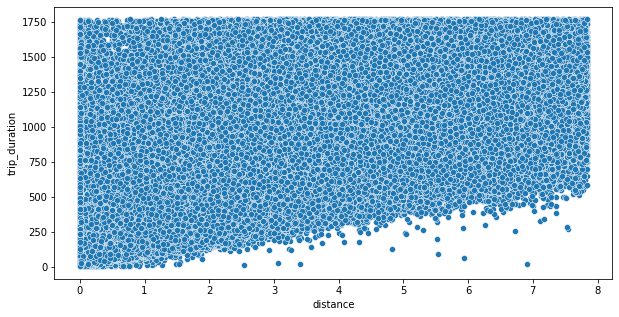

In [96]:
fig = plt.figure(figsize=(10, 5))
sns.scatterplot(x='distance',y='trip_duration',data=taxi_df)

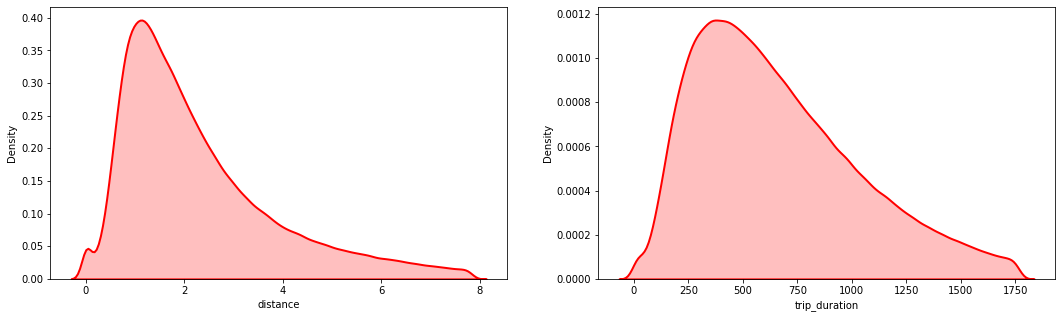

In [98]:
figure, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,5))
sns.distplot(taxi_df['distance'], hist=False, kde=True, kde_kws= {'shade':True, 'linewidth':2}, color="red", ax=ax[0])
sns.distplot(taxi_df['trip_duration'], hist=False, kde=True, kde_kws= {'shade':True, 'linewidth':2}, color="red", ax=ax[1])

In [119]:
taxi_df=pd.get_dummies(taxi_df, columns=['store_and_fwd_flag', 'pickup_day', 'dropoff_day'])

In [121]:
taxi_df['trip_duration_hour']=taxi_df['trip_duration']/3600

In [122]:
taxi_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,...,pickup_day_Tuesday,pickup_day_Wednesday,dropoff_day_Friday,dropoff_day_Monday,dropoff_day_Saturday,dropoff_day_Sunday,dropoff_day_Thursday,dropoff_day_Tuesday,dropoff_day_Wednesday,trip_duration_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,...,0,0,0,1,0,0,0,0,0,0.126389
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,...,0,0,0,0,0,1,0,0,0,0.184167
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429,...,0,1,0,0,0,0,0,0,1,0.119167
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435,...,0,0,0,0,1,0,0,0,0,0.120833
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,1551,...,0,0,0,0,1,0,0,0,0,0.430833


In [129]:
features=['vendor_id', 'passenger_count', 'distance', 'pickup_hour', 'dropoff_hour', 'pickup_month', 'pickup_year', 'dropoff_month', 'dropoff_year', 'store_and_fwd_flag_N', 
          'store_and_fwd_flag_Y', 'pickup_day_Friday', 'pickup_day_Monday', 'pickup_day_Saturday', 'pickup_day_Sunday', 'pickup_day_Thursday', 'pickup_day_Tuesday',
          'pickup_day_Wednesday', 'dropoff_day_Friday', 'dropoff_day_Monday', 'dropoff_day_Saturday', 'dropoff_day_Sunday', 'dropoff_day_Thursday', 'dropoff_day_Tuesday',
          'dropoff_day_Wednesday', 'trip_duration_hour']

In [130]:
final_df=taxi_df[features]

## Evaluating which model is better. Therefore we will be calculating evaluation metrics for different models

In [104]:
from matplotlib import legend
# Defining a function to calculate evaluation metrics
def EM(x_train,y_train,y_predicted,disp="on"):
  ''' Takes different set of parameters and prints evaluation metrics '''
  MSE=round(mean_squared_error(y_true=y_train,y_pred=y_predicted),4)
  RMSE=(np.sqrt(MSE))
  R2=(r2_score(y_true=y_train,y_pred=y_predicted))
  Adjusted_R2=(1-(1-r2_score(y_train, y_predicted))*((x_train.shape[0]-1)/(x_train.shape[0]-x_train.shape[1]-1)))
  if disp=="on":
    print("Mean Squared Error:",MSE,"Root Mean Squared Error:", RMSE)
    print("R2 Score :",R2,"Adjusted R2 Score :",Adjusted_R2)

  # #Plotting Actual and Predicted Values
  # plt.figure(figsize=(18,6))
  # plt.plot((y_predicted)[:100]) 
  # plt.plot((np.array(y_train)[:100]))
  # plt.legend(["Predicted","Actual"])
  # plt.title('Actual and Predicted Time Duration')


  
  return (MSE,RMSE,R2,Adjusted_R2) 

In [134]:
brief()

,Null Count,Dtype
id,0,object
vendor_id,0,int64
pickup_datetime,0,datetime64[ns]
dropoff_datetime,0,datetime64[ns]
passenger_count,0,int64
pickup_longitude,0,float64
pickup_latitude,0,float64
dropoff_longitude,0,float64
dropoff_latitude,0,float64
trip_duration,0,int64


In [131]:
#For Standarization  apply z-score
from scipy.stats import zscore

#Train test split
x = taxi_df[features].apply(zscore)[:100000]
y=taxi_df['trip_duration_hour'][:100000]

# Importing train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(80000, 26) (80000,)
(20000, 26) (20000,)


## **LINEAR REGRESSION**